# Plot 1: Mood Bias Demonstration

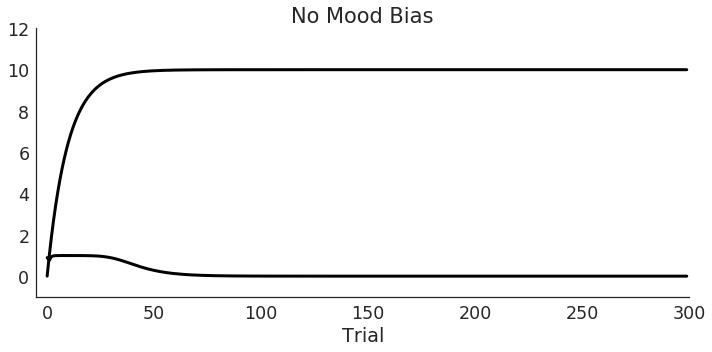

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.75)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Simulate data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Agent parameters.
parameters = [[10, 0.1, 0.1, 1.0],
              [10, 0.1, 0.1, 1.2]]
m = 0.9

## Task parameters.
R = np.ones(300) * 10

## Preallocate space.
Q = np.zeros((R.size, len(parameters)))
h = np.zeros_like(Q)
M = np.zeros_like(Q)
M[0] += m

## Simulate data.
for j, params in enumerate(parameters):

    ## Unpack parameters.
    beta, eta_v, eta_h, f = params

    for i in np.arange(R.size-1):
        
        ## Compute reward prediction error.
        delta = (f ** M[i,j]) * R[i] - Q[i,j]
        
        ## Update expectations.
        Q[i+1,j] = Q[i,j] + eta_v * delta

        ## Update mood.
        h[i+1,j] = h[i,j] + eta_h * (delta - h[i,j])
        M[i+1,j] = np.tanh(h[i+1,j])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(10,5))
    
## Plot expectations / mood.
ax.plot(Q[:,0], lw=3, color='k')
ax.plot(M[:,0], lw=3, color='k')
    
## Add info.
ax.set(xlim=(-5,300), ylim=(-1,12), xlabel='Trial', title='No Mood Bias')
        
sns.despine()
plt.tight_layout()

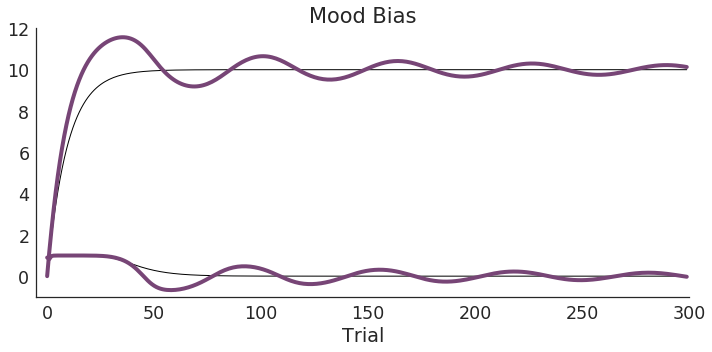

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(10,5))
    
## Plot expectations / mood.
ax.plot(Q[:,0], lw=1, color='k')
ax.plot(Q[:,1], lw=4, color='#774576')
ax.plot(M[:,0], lw=1, color='k')
ax.plot(M[:,1], lw=4, color='#774576')

    
## Add info.
ax.set(xlim=(-5,300), ylim=(-1,12), xlabel='Trial', title='Mood Bias')
        
sns.despine()
plt.tight_layout()

## Plot 2: Change in mood

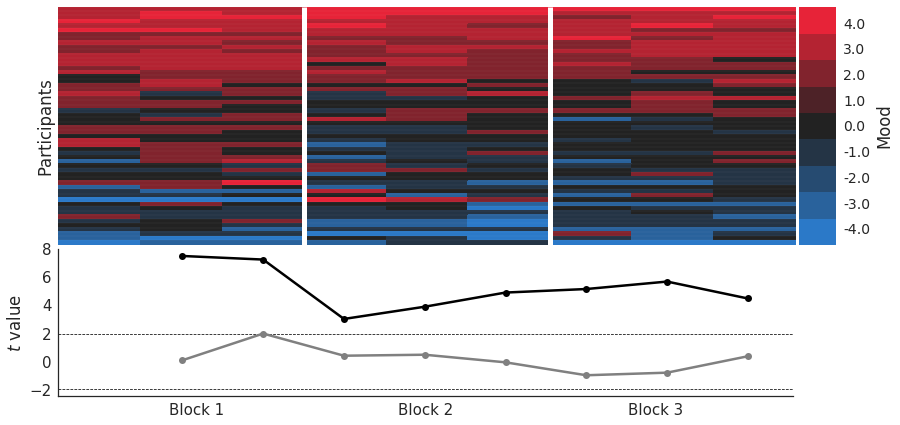

In [88]:
from pandas import read_csv
from statsmodels.api import OLS
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load data.
ratings = read_csv('data/moodRL_ratings.csv')
metadata = read_csv('data/moodRL_metadata.csv')

## Subset data.
mood = ratings[np.logical_and(ratings.Variable=='Mood', ratings.Trial > 0)].copy()

## Define metadata.
n_subjects = mood.Datetime.unique().size
trials = np.unique( (mood.Block-1) * 42 + mood.Trial)
n_trials = trials.size

## Extract and reshape mood data.
mood = mood.Rating.values.reshape(n_subjects, n_trials)

## Sort.
sort_ix = np.argsort(mood.mean(axis=-1))
mood = mood[sort_ix[::-1]]

## Construct design matrix.
X = np.vstack([np.ones(n_subjects), 
               mood[:,0], 
               np.where(metadata.WoF > 0, 1, 0)]).T

## Preallocate space.
t = np.zeros((n_trials - 1, X.shape[-1]))

for i, y in enumerate(mood[:,1:].T):
    fit = OLS(y, X).fit()
    t[i] = fit.tvalues

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig = plt.figure(figsize=(12,6))

## Initialize canvas and divider.
gs = gridspec.GridSpec(1,1)
gs.update(left=0.05, right=0.95, bottom=0.4, top=0.95, hspace=0, wspace=0)
ax = plt.subplot(gs[0, 0])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

## Plot.
cmap = sns.diverging_palette(250, 10, s=90, l=50, n=9, center="dark")
sns.heatmap(mood, vmin=-3, vmax=3, cmap=cmap,  ax=ax, cbar_ax=cax)

## Add info.
ax.vlines([3,6], 0, n_subjects, lw=5, color='w')
ax.hlines(np.arange(n_subjects), 0, n_trials, lw=0.05, color='w')
ax.set(xticks=[], yticks=[], ylabel='Participants')

## Update colorbar.
cbar = ax.collections[0].colorbar
cbar.set_ticks(np.linspace(-4,4,9)*0.65)
cbar.ax.set_yticklabels(np.linspace(-4,4,9), fontsize=14)
cax.set_ylabel(r'Mood', labelpad=5)

## Plot time series.
gs = gridspec.GridSpec(1,1)
gs.update(left=0.05, right=0.9, bottom=0.05, top=0.39, hspace=0)
ax = plt.subplot(gs[0, 0])

ax.plot(np.arange(1.35,8,0.88), t[:,1], lw=2.5, marker='o', color='k')
ax.plot(np.arange(1.35,8,0.88), t[:,2], lw=2.5, marker='o', color='grey')
ax.hlines([-1.96,1.96], 0, 8, lw=0.75, linestyle='--')
ax.set(xlim=(0,8), xticks=[1.5,4,6.5], xticklabels=['Block 1', 'Block 2', 'Block 3'],
      yticks=np.arange(-2,10,2), ylabel=r'$t$ value')
sns.despine(ax=ax)

# Plot 3: Reward perception

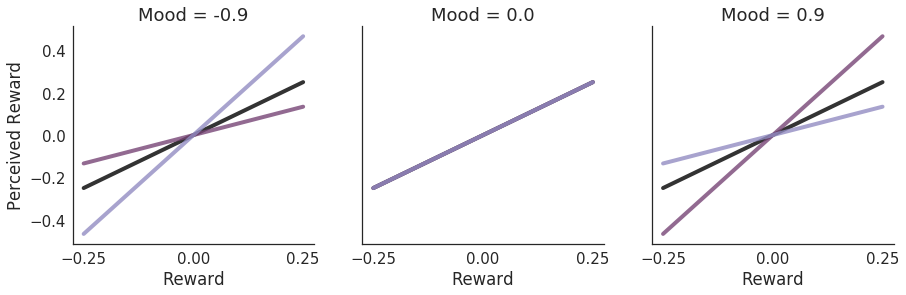

In [6]:
sns.set_context('notebook', font_scale=1.5)

## Define bias function and rewards.
bias = lambda x, f, m: x * f ** m
reward = np.linspace(-0.25, 0.25, 101)

## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4),sharex=True,sharey=True)

## Plot.
for ax, m in zip(axes, [-0.9, 0.0, 0.9]):
    
    for f, color in zip([1, 2, 0.5], ['k', '#774576', '#928cc2']):
        
        ax.plot(reward, bias(reward, f, m), lw=4, color=color, label=r'$f = %0.2f$' %f, alpha=0.8)
    
    ax.set(xticks=np.linspace(reward.min(),reward.max(),3), xlabel='Reward',
           title='Mood = %0.1f' %m)
    
axes[0].set_ylabel('Perceived Reward')
sns.despine()
plt.subplots_adjust(left=0.05,right=1)

# Plot 4: Wald Distribution

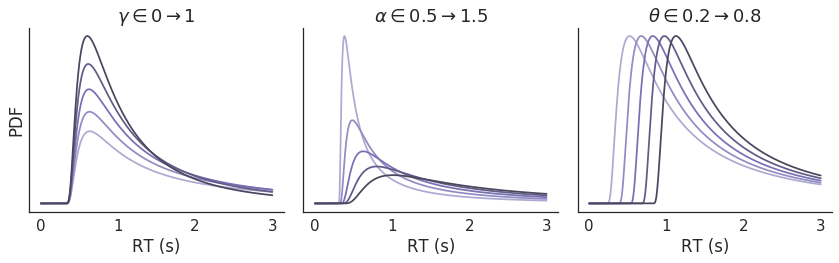

In [114]:
from scripts.wald import shifted_wald_pdf

## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4))
palette = sns.color_palette('Purples_d', n_colors=5).as_hex()
x = np.linspace(0,3,1000)

## Increase gamma.
for gamma, color in zip(np.linspace(0,1,5), palette[::-1]):
    axes[0].plot(x, shifted_wald_pdf(x, gamma, 1, 0.3), color=color)
axes[0].set(xlabel='RT (s)', yticks=[], ylabel='PDF', title=r'$\gamma \in 0 \rightarrow 1$')
    
## Increase alpha.
for alpha, color in zip(np.linspace(0.5,1.5,5), palette[::-1]):
    axes[1].plot(x, shifted_wald_pdf(x, 0.5, alpha, 0.3), color=color)
axes[1].set(xlabel='RT (s)', yticks=[], title=r'$\alpha \in 0.5 \rightarrow 1.5$')
    
## Increase theta.
for theta, color in zip(np.linspace(0.2,0.8,5), palette[::-1]):
    axes[2].plot(x, shifted_wald_pdf(x, 0.5, 1, theta), color=color)
axes[2].set(xlabel='RT (s)', yticks=[], title=r'$\theta \in 0.2 \rightarrow 0.8$')

sns.despine()
plt.tight_layout()